In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from math import pi, floor, exp, ceil, radians
import sys

## 1) Q1)4) Graphs
## 3) sort out the graphs

In [2]:
def cvtGrayscale(img):
    if len(img.shape) < 3:
        return img
    b, l, c = img.shape
    gray = np.zeros((b,l), dtype = "int64")
    for i in range(b):
        for j in range(l):
            gray[i][j] = (0.299*img[i][j][0] + 0.587*img[i][j][1] + 0.114*img[i][j][2])
    return gray

### Q1) The implementation of linear spatial filters requires moving a mask centered at each pixel of the image, computing sum of products of mask coefficients and corresponding pixels. Padding can be used to perform filtering at the corners. Apply all the techniques to ceramic.jpg.

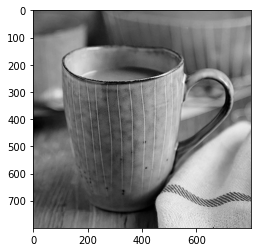

In [3]:
img_cer = cv2.imread("../images/ceramic.jpg")
img_cer = cv2.cvtColor(img_cer, cv2.COLOR_BGR2RGB)
img_cer = cvtGrayscale(img_cer)
img_cer16 = cv2.resize(img_cer.astype("float32"), (16,16))
img_cer32 = cv2.resize(img_cer.astype("float32"), (32,32))
img_cer64 = cv2.resize(img_cer.astype("float32"), (64,64))
img_cer128 = cv2.resize(img_cer.astype("float32"), (128,128))
img_cer256 = cv2.resize(img_cer.astype("float32"), (256,256))
img_cer512 = cv2.resize(img_cer.astype("float32"), (512,512))
plt.imshow(img_cer, cmap = "gray")

In [4]:
def padding(img, k, fill):
    b, l, c = img.shape
    out = np.zeros((b+2*(k//2), l+2*(k//2), c), dtype="int64")
    out[k//2:b+k//2, k//2:l+k//2, 0:3] = img
    if fill == 0:
        pass
    elif fill == 1: 
        out[0:k//2,0:l + 2*(k//2), 0:3] = 255
        out[b+k//2:b + 2*(k//2),0:l + 2*(k//2), 0:3] = 255
        out[k//2:b+k//2, 0:k//2, 0:3] = 255
        out[k//2:b+k//2, l + k//2: l + 2*(k//2), 0:3] = 255
    else:
        return -1
        
    return out

#plt.imshow(padding(img_color, 51, 0))

### 1. Implement an algorithm for low-pass filtering a grayscale image by moving a k × k averaging filter of the form ones((k,k))/(k 2 ). Try with k = 3, 5, 7, 11 and 13. (Note: Ones((k,k))/(k 2 ) implies a filter with all the entries of a k*k matrix as 1/(k 2 ).

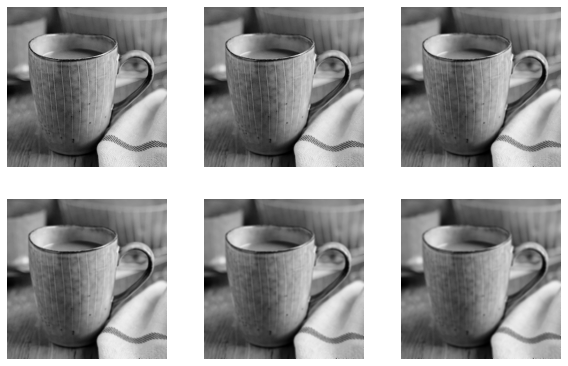

In [5]:
def lowPass(img,k):
    b, l = img.shape
    #print(img.shape)
    out = np.copy(img)
    #print(kernel)
    st = time.time()
    for i in range(k//2,(b-(k//2))):
        for j in range(k//2,(l-(k//2))):
            p= k//2
            if k != 1:
                tmp = img[i-p:i+p+1,j-p:j+p+1]
            else:
                tmp = img[i][j]
            out[i][j] = np.sum(tmp*(1/(k**2)))
    t = time.time()-st
    return out, t

times_norm = np.zeros(6)
plt.figure(figsize=(10,10))
for f in range(6):
    plt.subplot(3,3,f+1)
    num = 2*f + 1
    img, t = lowPass(img_cer, num )
    times_norm[f] = t
    plt.imshow(img,cmap="gray")
    plt.axis("off")

### 2. As the filter is moved from one spatial location to the next one, the filter window shares many common pixels in adjacent neighborhoods. Exploit this observation and implement a more efficient version of averaging filter.

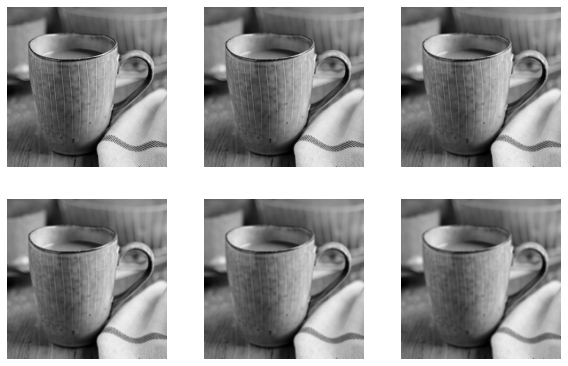

In [6]:
def lowPass1(img,k):
    b,l = img.shape
    out = np.copy(img)
    p = k//2
    rcol = k
    lcol = 0
    st = time.time()
    for i in range(k//2,(b-(k//2))):
        rcol = k
        lcol = 0
        tmp = np.sum(img[i-p:i+p+1,lcol:rcol])                 
        for j in range(k//2,(l-(k//2))):
            out[i][j] = (tmp)*(1/k**2)
            rcol += 1
            delta = np.sum(img[i-p:i+p+1,min(rcol-1,l-1)] - img[i-p:i+p+1,lcol])
            tmp += delta
            lcol += 1
    t = time.time()-st
    return out,t

times_opt = np.zeros(6)
plt.figure(figsize=(10,10))
for f in range(6):
    plt.subplot(3,3,f+1)
    num = 2*f + 1
    img, t = lowPass1(img_cer, num )
    plt.imshow(img,cmap="gray")
    plt.axis("off")

### 3. To appreciate the benefits of the efficient version, generate a plot of k vs run-time for multiple images of different sizes (8x8, 16x16, 32x32, .. 512x512) by resizing ceramic.jpg. The plot diagram should contain a line plot for each image size. Use different marker types to distinguish the default implementation and improved implementation. Just to give you a rough idea, look at https://imgur.com/a/0HtYlTE.

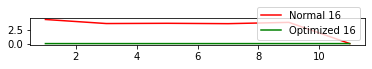

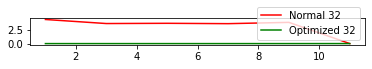

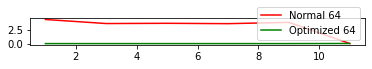

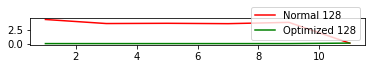

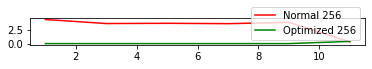

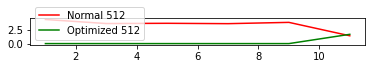

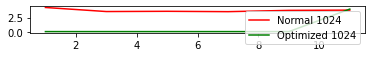

In [7]:
x_axis = np.array([1,3,5,7,9,11])
images = [img_cer16,img_cer32,img_cer64,img_cer128,img_cer256,img_cer512, img_cer]
p=0
for img in images:
    for i in range(6):
        num = 2*f + 1
        im, t = lowPass1(img, num )
        times_opt[f] = t
        im, t = lowPass(img, num)
        times_norm[f] = t

    plt.subplot(7,1,i+1)
    plt.plot(x_axis, times_norm, 'r',label = "Normal " + str(16*(2**p)))
    plt.plot(x_axis, times_opt, 'g',label = "Optimized " + str(16*(2**p)))
    plt.legend()
    plt.show()
    p += 1




### 4. Utilize the observation similar to above to implement an efficient version of a k × k median filter. Generate a plot figure similar to previous question.

In [8]:
def medianFilter(img, k):
    b ,l = img.shape
    out = np.copy(img)
    p = k//2
    rcol = k
    lcol = 0
    st = time.time()
    for i in range(k//2,(b-(k//2))):
        for j in range(k//2,(l-(k//2))):
            p= k//2
            if k != 1:
                tmp = img[i-p:i+p+1,j-p:j+p+1]
            else:
                tmp = img[i][j]
            out[i][j] = np.median(tmp)
    t = time.time()-st
    return out,t

In [9]:
def medianFilter1(img, k):
    b ,l = img.shape
    out = np.copy(img)
    p = k//2
    rcol = k
    lcol = 0
    st = time.time()
    for i in range(k//2,(b-(k//2))):
        rcol = k
        lcol = 0
        tmp = img[i-p:i+p+1,lcol:rcol]
        for j in range(k//2,(l-(k//2))):
            out[i][j] = np.median(tmp)
            rcol += 1
            #delta = np.sum(img[i-p:i+p+1,min(rcol-1,l-1)] - img[i-p:i+p+1,lcol])
            tmp[0:k,0:k-1] = tmp[0:k, 1:k]
            tmp[0:k,k-1] = img[i-p:i+p+1,min(rcol-1,l-1)]
            lcol += 1
    t = time.time()-st
    return out,t

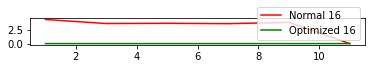

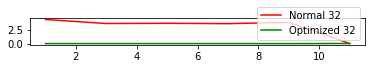

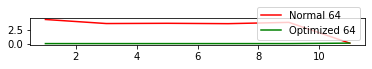

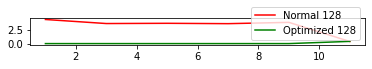

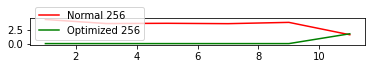

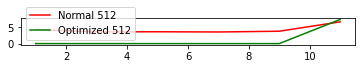

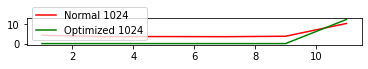

In [10]:
x_axis = np.array([1,3,5,7,9,11])
images = [img_cer16,img_cer32,img_cer64,img_cer128,img_cer256,img_cer512, img_cer]
p=0
for img in images:
    for i in range(6):
        num = 2*f + 1
        im, t = medianFilter1(img, num )
        times_opt[f] = t
        im, t = medianFilter(img, num)
        times_norm[f] = t
    plt.subplot(7,1,f+1)
    plt.plot(x_axis, times_norm, 'r',label = "Normal " + str(16*(2**p)))
    plt.plot(x_axis, times_opt, 'g',label = "Optimized " + str(16*(2**p)))
    p += 1
    plt.legend()
    plt.show()



### 5. After observing the image brainNoisy.jpg, answer the following questions:
###   • Which filter will be the best suited to remove the noise and why?
###      Ans: Median filter will work best since there is both salt and pepper noise in the image
###   • Experiment with different filter sizes and report your observations. Which filter size is optimal?
###   • Get brainNoisy.jpg to resemble the original brain.jpg as much as possible by removing the noise.

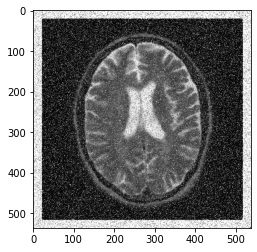

In [11]:
img_brain = cv2.imread("../images/brainNoisy.jpg")
img_brain = cvtGrayscale(img_brain)
img_ideal = cv2.imread("../images/brain.jpg")
img_ideal = cvtGrayscale(img_ideal)
plt.imshow(img_brain, cmap="gray")


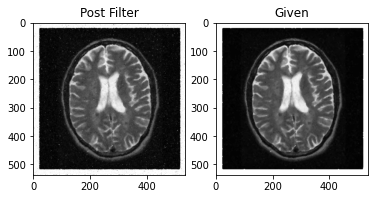

In [12]:
img_out, t = medianFilter1(img_brain, 3)
plt.subplot(1,2,1)
plt.title("Post Filter")
plt.imshow(img_out, cmap="gray")
plt.subplot(1,2,2)
plt.title("Given")
plt.imshow(img_ideal, cmap="gray")

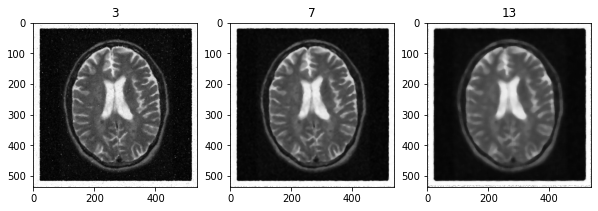

In [13]:
plt.figure(figsize=(10,10))
plt.axis("off")
plt.subplot(131)
plt.title(3)
img_out, t = medianFilter1(img_brain, 3)
plt.imshow(img_out, cmap="gray")
plt.subplot(132)
plt.title(7)
img_out, t = medianFilter1(img_brain, 7)
plt.imshow(img_out, cmap="gray")
plt.subplot(133)
plt.title(13)
img_out, t = medianFilter1(img_brain, 13)
plt.imshow(img_out, cmap="gray")

#### For small filter sizes overall image is not affected apart from, noise removal. For larger filter sizes an averaging effect is seen since larger number of pixels are affected in the same way.

## Q2) Edge Detection

### 1. Read about Canny Edge detector. Apply the Canny edge detector (use inbuilt cv2.Canny function for this task) to cup.jpg.

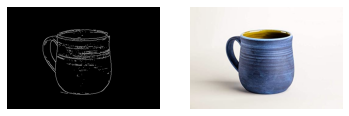

In [14]:
img_cup = cv2.imread('../images/cup.jpg')
edges = cv2.Canny(img_cup, 200, 200)
plt.subplot(121)
plt.axis("off")
plt.imshow(edges, cmap="gray")
plt.subplot(122)
plt.axis("off")
plt.imshow(img_cup, cmap="gray")

### 2. Tweak the values of the arguments (minVal and maxVal ), and report the values. that give the best results for each image. (Hint: Try to get a good outline of the cup without too many fine lines.)

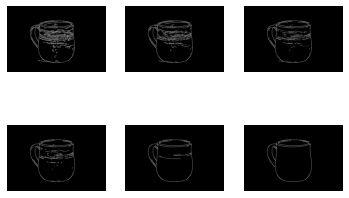

In [15]:
plt.subplot(231)
plt.axis("off")
plt.imshow(cv2.Canny(img_cup, 100, 200), cmap="gray")
plt.subplot(232)
plt.axis("off")
plt.imshow(cv2.Canny(img_cup, 150, 200), cmap="gray")
plt.subplot(233)
plt.axis("off")
plt.imshow(cv2.Canny(img_cup, 200, 200), cmap="gray")
plt.subplot(234)
plt.axis("off")
plt.imshow(cv2.Canny(img_cup, 250, 200), cmap="gray")
plt.subplot(235)
plt.axis("off")
plt.imshow(cv2.Canny(img_cup, 450, 200), cmap="gray")
plt.subplot(236)
plt.axis("off")
plt.imshow(cv2.Canny(img_cup, 650, 200), cmap="gray")

#### Therefore the values are: (650,200)

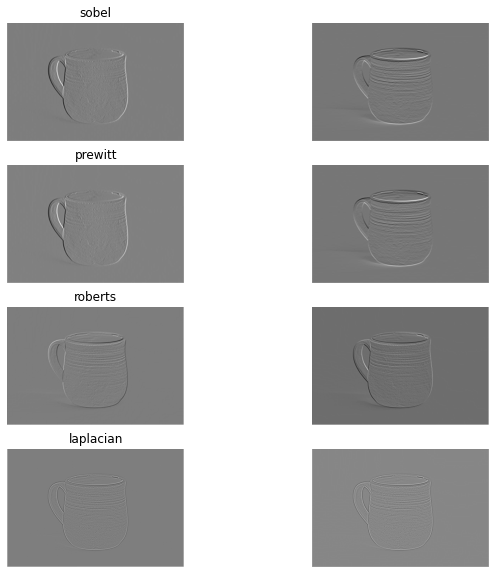

In [16]:
img_cup = cvtGrayscale(img_cup)
def sobel(img, k, d):
    kernel = np.zeros((k,k), dtype="int64")
    b, l = img.shape
    out = np.copy(img)
    if d == 0:
        kernel[0:k,0] = -1
        kernel[0:k,k-1] = 1
        kernel[k//2][0] = -2
        kernel[k//2][k-1] = 2
    if d == 1:
        kernel[0,0:k] = -1
        kernel[k-1,0:k] = 1
        kernel[0][k//2] = -2
        kernel[k-1][k//2] = 2
        
    for i in range(k//2,(b-(k//2))):
        for j in range(k//2,(l-(k//2))):
            p= k//2
            if k != 1:
                tmp = img[i-p:i+p+1,j-p:j+p+1]
            else:
                tmp = img[i][j]
            out[i][j] = np.sum(tmp*kernel)
    return out

def prewitt(img, k, d):
    kernel = np.zeros((k,k), dtype="int64")
    b, l = img.shape
    out = np.copy(img)
    if d == 0:
        kernel[0:k,0] = -1
        kernel[0:k,k-1] = 1
    elif d == 1:
        kernel[0,0:k] = -1
        kernel[k-1,0:k] = 1
        
    for i in range(k//2,(b-(k//2))):
        for j in range(k//2,(l-(k//2))):
            p= k//2
            if k != 1:
                tmp = img[i-p:i+p+1,j-p:j+p+1]
            else:
                tmp = img[i][j]
            out[i][j] = np.sum(tmp*kernel)
    return out

def robert(img, d):
    b, l = img.shape
    out = np.copy(img)
    kernel = np.zeros((2,2))
    if d == 0:
        kernel = np.array([[1,0],[0,-1]])
    elif d == 1:
        kernel = np.array([[0,1],[-1,0]])
    
    for i in range(b-1):
        for j in range(l-1):
            tmp = img[i:i+2,j:j+2]
            out[i][j] = np.sum(tmp*kernel)
    return out

def laplacian(img, d):
    b, l = img.shape
    kernel = np.zeros((3,3))
    out = np.copy(img)
    if d == 0:
        kernel = np.array([[0,1,0],[1,-4,1],[0,1,0]])
    elif d == 1:
        kernel = np.array([[1,1,1],[1,-8,1],[1,1,1]])
    k = 3
    
    for i in range(k//2,(b-(k//2))):
        for j in range(k//2,(l-(k//2))):
            p= k//2
            if k != 1:
                tmp = img[i-p:i+p+1,j-p:j+p+1]
            else:
                tmp = img[i][j]
            out[i][j] = np.sum(tmp*kernel)
    return out


plt.figure(figsize=(10,10))
plt.subplot(421)
plt.axis("off")
plt.title("sobel")
plt.imshow(sobel(img_cup, 3, 0),cmap="gray")
plt.subplot(422)
plt.axis("off")
plt.imshow(sobel(img_cup, 3, 1), cmap="gray")
plt.subplot(423)
plt.title("prewitt")
plt.axis("off")
plt.imshow(prewitt(img_cup, 3, 0),cmap="gray")
plt.subplot(424)
plt.axis("off")
plt.imshow(prewitt(img_cup, 3, 1), cmap="gray")
plt.subplot(425)
plt.title("roberts")
plt.axis("off")
plt.imshow(robert(img_cup, 0),cmap="gray")
plt.subplot(426)
plt.axis("off")
plt.imshow(robert(img_cup, 1), cmap="gray")
plt.subplot(427)
plt.title("laplacian")
plt.axis("off")
plt.imshow(laplacian(img_cup, 0),cmap="gray")
plt.subplot(428)
plt.axis("off")
plt.imshow(laplacian(img_cup, 1), cmap="gray")

#### Sobel and Prewitt filters have almost similar outputs, on the other hand roberts filter show changes along 45 and -45 degree directions. While laplacian filter has a less discernable output

### 4. What will the 5×5 variants of Sobel and Prewitt filters look like? Apply these larger filters on girl.jpg and make observations upon comparing their outputs with the corresponding smaller filters.

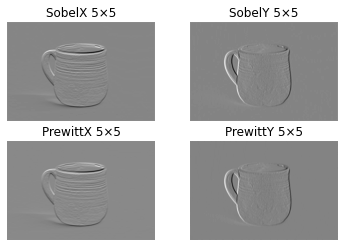

In [17]:
def sobel5(img, d):
    b,l = img.shape
    out = np.copy(img)
    if d == 0:
        kernel = np.array([[2,2,4,2,2],[1,1,2,1,1],[0,0,0,0,0],[-1,-1,-2,-1,-1],[-2,-2,-4,-2,-2]])
    elif d == 1:
        kernel = np.array([[2,1,0,-1,-2],[2,1,0,-1,-2],[4,2,0,-2,-4],[2,1,0,-1,-2],[2,1,0,-1,-2]])
    k = 5
    
    for i in range(k//2,(b-(k//2))):
        for j in range(k//2,(l-(k//2))):
            p= k//2
            if k != 1:
                tmp = img[i-p:i+p+1,j-p:j+p+1]
            else:
                tmp = img[i][j]
            out[i][j] = np.sum(tmp*kernel)
    return out
    
def prewitt5(img, d):
    b,l = img.shape
    out = np.copy(img)
    if d == 0:
        kernel = np.array([[9,9,9,9,9],[9,5,5,5,9],[-7,-3,0,-3,-7],[-7,-3,-3,-3,-7],[-7,-7,-7,-7,-7]])
    elif d == 1:
        kernel = np.array([[9,9,-7,-7,-7],[9,5,-3,-3,-7],[9,5,0,-3,-7],[9,5,-3,-3,-7],[9,9,-7,-7,-7]])
    k = 5
    
    for i in range(k//2,(b-(k//2))):
        for j in range(k//2,(l-(k//2))):
            p= k//2
            if k != 1:
                tmp = img[i-p:i+p+1,j-p:j+p+1]
            else:
                tmp = img[i][j]
            out[i][j] = np.sum(tmp*kernel)
    return out

plt.subplot(221)
plt.axis("off")
plt.title("SobelX 5×5")
plt.imshow(sobel5(img_cup, 0),cmap="gray")
plt.subplot(222)
plt.axis("off")
plt.title("SobelY 5×5")
plt.imshow(sobel5(img_cup, 1), cmap="gray")
plt.subplot(223)
plt.axis("off")
plt.title("PrewittX 5×5")
plt.imshow(prewitt5(img_cup, 0),cmap="gray")
plt.subplot(224)
plt.axis("off")
plt.title("PrewittY 5×5")
plt.imshow(prewitt5(img_cup, 1), cmap="gray")

#### We can see that the edges are thicker when using a 5×5

### 5. Zero-mean gaussian noise with σ = 10 and σ = 30 has been added to girl.jpg to obtain girlNoisy1.jpg and girlNoisy2.jpg, respectively. Study the effect of applying the above filters (from 2 nd Question) on the noise affected inputs.

Girl Noisy1


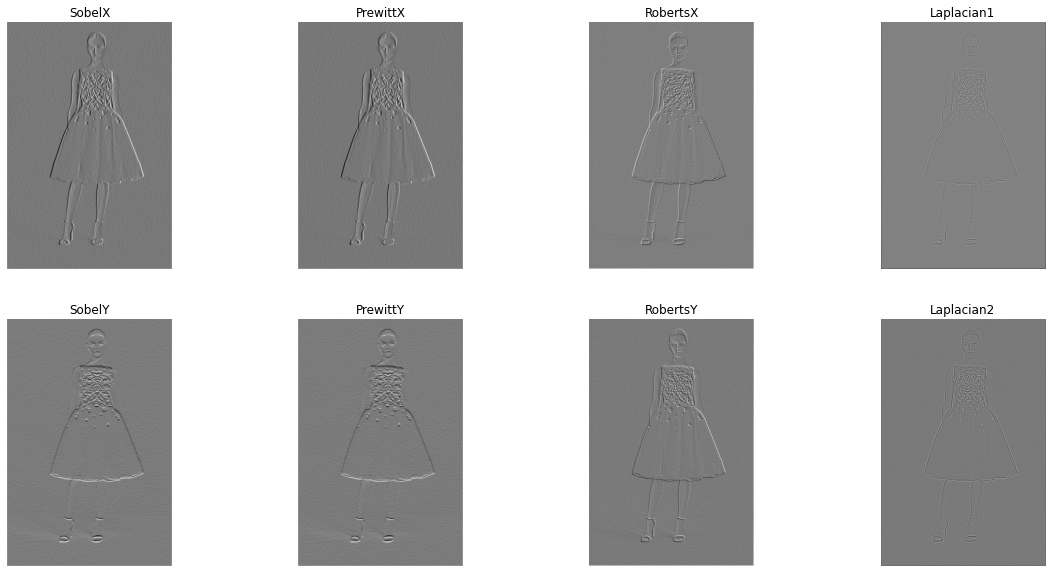

In [18]:
img_noisy1 = cv2.imread("../images/girlNoisy1.jpg")
img_noisy1 = cv2.cvtColor(img_noisy1, cv2.COLOR_BGR2RGB)
img_noisy1 = cvtGrayscale(img_noisy1)
img_noisy2 = cv2.imread("../images/girlNoisy2.jpg")
img_noisy2 = cv2.cvtColor(img_noisy2, cv2.COLOR_BGR2RGB)
img_noisy2 = cvtGrayscale(img_noisy2)

print("Girl Noisy1")
plt.figure(figsize=(20,10))
plt.subplot(241)
plt.title("SobelX")
plt.axis("off")
plt.imshow(sobel(img_noisy1, 3,  0), cmap="gray")
plt.subplot(245)
plt.title("SobelY")
plt.axis("off")
plt.imshow(sobel(img_noisy1, 3,  1), cmap="gray")
plt.subplot(242)
plt.title("PrewittX")
plt.axis("off")
plt.imshow(prewitt(img_noisy1, 3,  0), cmap="gray")
plt.subplot(246)
plt.title("PrewittY")
plt.axis("off")
plt.imshow(prewitt(img_noisy1, 3,  1), cmap="gray")
plt.subplot(243)
plt.title("RobertsX")
plt.axis("off")
plt.imshow(robert(img_noisy1, 0), cmap="gray")
plt.subplot(247)
plt.title("RobertsY")
plt.axis("off")
plt.imshow(robert(img_noisy1, 1), cmap="gray")
plt.subplot(244)
plt.title("Laplacian1")
plt.axis("off")
plt.imshow(255 - laplacian(img_noisy1, 0), cmap="gray")
plt.subplot(248)
plt.title("Laplacian2")
plt.axis("off")
plt.imshow(255 - laplacian(img_noisy1, 1), cmap="gray")

Girl Noisy2


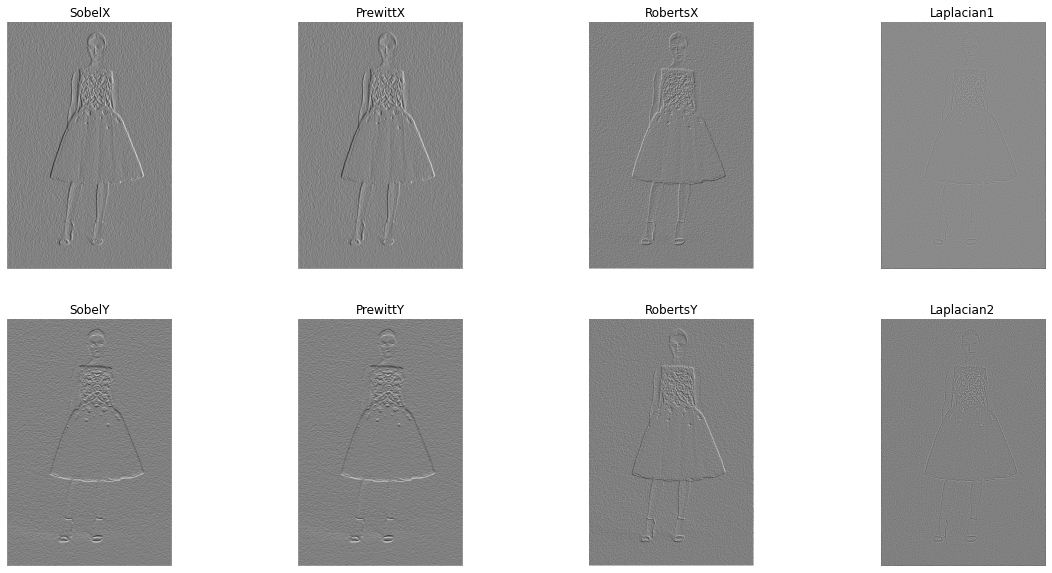

In [19]:
print("Girl Noisy2")
plt.figure(figsize=(20,10))
plt.subplot(241)
plt.title("SobelX")
plt.axis("off")
plt.imshow(sobel(img_noisy2, 3,  0), cmap="gray")
plt.subplot(245)
plt.title("SobelY")
plt.axis("off")
plt.imshow(sobel(img_noisy2, 3,  1), cmap="gray")
plt.subplot(242)
plt.title("PrewittX")
plt.axis("off")
plt.imshow(prewitt(img_noisy2, 3,  0), cmap="gray")
plt.subplot(246)
plt.title("PrewittY")
plt.axis("off")
plt.imshow(prewitt(img_noisy2, 3,  1), cmap="gray")
plt.subplot(243)
plt.title("RobertsX")
plt.axis("off")
plt.imshow(robert(img_noisy2, 0), cmap="gray")
plt.subplot(247)
plt.title("RobertsY")
plt.axis("off")
plt.imshow(robert(img_noisy2, 1), cmap="gray")
plt.subplot(244)
plt.title("Laplacian1")
plt.axis("off")
plt.imshow(255 - laplacian(img_noisy2, 0), cmap="gray")
plt.subplot(248)
plt.title("Laplacian2")
plt.axis("off")
plt.imshow(255 - laplacian(img_noisy2, 1), cmap="gray")

#### OBSERVATION: In case of Sobel and rewitt filters the effect of noise is clearly visible in both the cases. On the other hand Roberts filter seems to be less affected in comparision to the noisy images, though there is visible disturbance for the second case. Laplacian looks least affected by noise out of all the above filters.

## Q3) Gaussian Filtering and Bilateral Filtering

### 1. Implement Gaussian filter and apply it to mountain.png. Vary σ value for filter size, 5x5. Find the optimal σ value for k=5 and compare the obtained outputs. Now vary the filter sizes (take optimal σ value for each filter size) and report your observations along with the images.
### Note: Optimal filter size for a given σ is the one that snugly fits 99% of the gaussian curve.

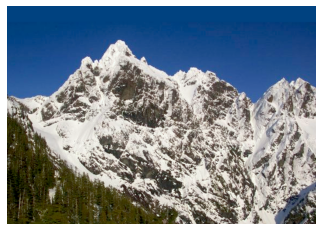

In [20]:
img_mount = cv2.imread("../images/mountain.png")
img_color = np.copy(img_mount)
img_color = cv2.cvtColor(img_color,cv2.COLOR_BGR2RGB)
img_mount = cv2.cvtColor(img_mount, cv2.COLOR_BGR2RGB)
img_mount = cvtGrayscale(img_mount)
plt.axis("off")
plt.imshow(img_color, cmap= "gray")


σ = 2/3 for kernel size = 5
σ = 2 for kernel size = 5
σ = 3 for kernel size = 5
σ = 4 for kernel size = 5
σ = 5 for kernel size = 5


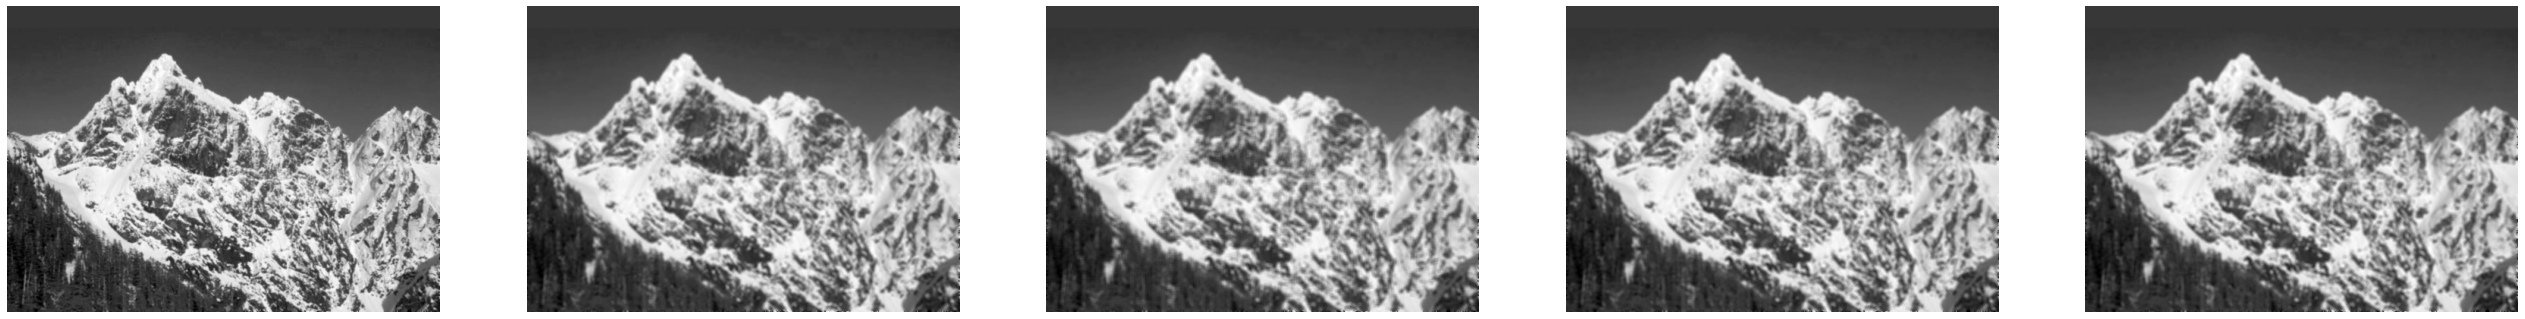

In [21]:
def gaussian(img, k, sigma):
    b, l = img.shape
    out = np.copy(img)
    kernel = np.zeros((k,k))
    s = 2*(sigma**2)
    for i in range(k):
        for j in range(k):
            kernel[i][j] = (1/pi*s)*(exp((-1)*((((i-k//2)**2) + ((j-k//2)**2))/s)))
    #print(kernel)
    kernel *= 1/(kernel[0][0])
    
    for i in range(k):
        for j in range(k):
            kernel[i][j] = floor(kernel[i][j])
    kernel /= np.sum(kernel)
    
    for i in range(k//2,(b-(k//2))):
        for j in range(k//2,(l-(k//2))):
            p= k//2
            if k != 1:
                tmp = img[i-p:i+p+1,j-p:j+p+1]
            else:
                tmp = img[i][j]
            out[i][j] = floor(np.sum(tmp*kernel))
            
    return out

fig = plt.figure(figsize = (45,10))
ax = fig.add_subplot(1,5,1)
t = "σ = 2/3 for kernel size = 5"
print(t)
ax.imshow(gaussian(img_mount, 5, 2/3), cmap="gray")
ax.axis("off")

for i in range(1, 5): 
    ax = fig.add_subplot(1,5,i+1)
    t = "σ = " + str(i+1) + " for kernel size = 5"
    print(t)
    ax.imshow(gaussian(img_mount, 5, i+1), cmap="gray")
    ax.axis("off")

#### For k = 5, the optimal σ will be 2/3. Since 99% of the gaussian surface is covered in a span of 6σ, k-1 = 6σ in optimal case 

σ = 1 for kernel size = 7
σ = 2 for kernel size = 7
σ = 3 for kernel size = 7
σ = 4 for kernel size = 7
σ = 5 for kernel size = 7


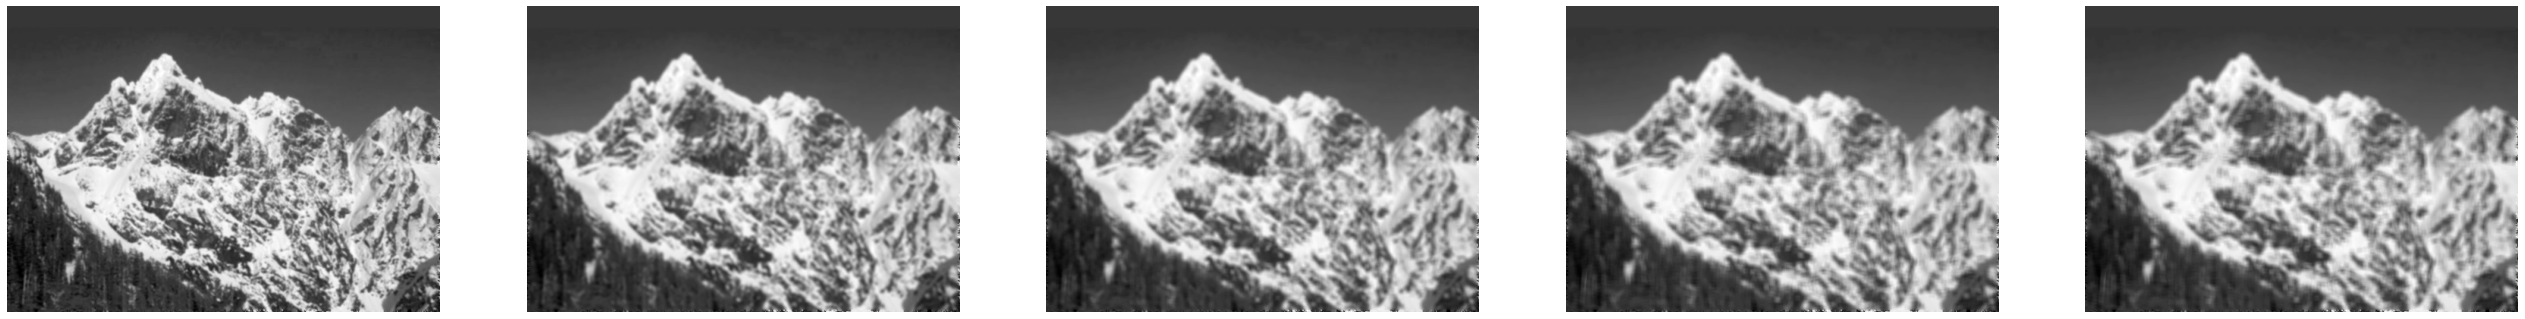

In [22]:
fig = plt.figure(figsize = (45,10))
for i in range(5): 
    ax = fig.add_subplot(1,5,i+1)
    t = "σ = " + str(i+1) + " for kernel size = 7"
    print(t)
    ax.imshow(gaussian(img_mount, 7, i+1), cmap="gray")
    ax.axis("off")

#### Optimal σ for k = 7 will be σ = (7-1)/6 = 1

σ = 1 for kernel size = 13
σ = 2 for kernel size = 13
σ = 3 for kernel size = 13
σ = 4 for kernel size = 13
σ = 5 for kernel size = 13


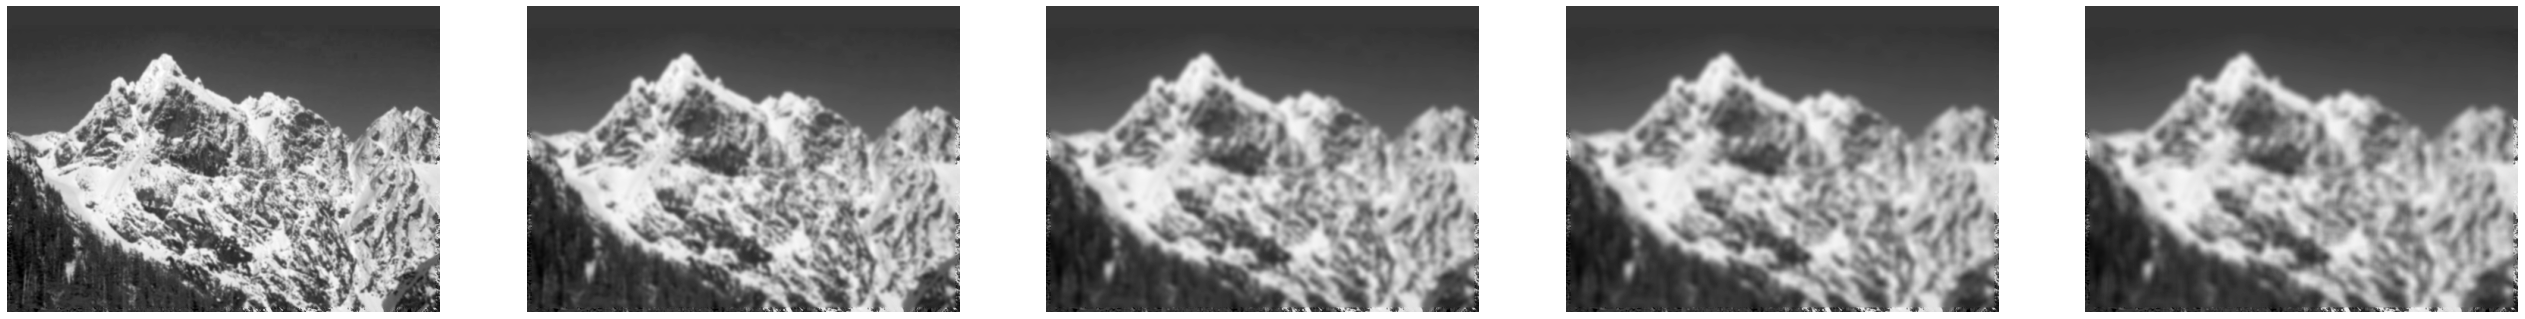

In [23]:
fig = plt.figure(figsize = (45,10))
for i in range(5): 
    ax = fig.add_subplot(1,5,i+1)
    t = "σ = " + str(i+1) + " for kernel size = 13"
    print(t)
    ax.imshow(gaussian(img_mount, 13, i+1), cmap="gray")
    ax.axis("off")

#### Optimal σ for k = 13 will be σ = (13-1)/6 = 2

#### OBSERVATIONS: In each case after increasing the σ higher that the optimal value, blurring of the image is clearly visible

### 2. Implement bilateral filtering and apply it to mountain.png.

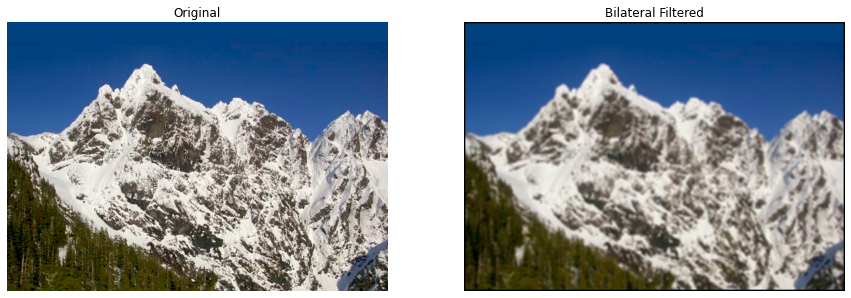

In [24]:
def G(val, sigma):
    s = 2*(sigma**2)
    if s==0:
        print("yes")
    ans = ((1/pi*s)*(exp((-1)*(val/s))))
    return ans
     

def bilateral(img, k, d, r):
    b, l,_ = img.shape
    out = np.zeros((b,l,3))
    d_kernel = np.zeros((k,k))
    r_kernel = np.zeros((k,k))
    s = 2*(d*d)*pi
    t = 2*(r*r)*pi
    
    for i in range(-k//2,k//2+1):
        for j in range(-k//2,k//2+1):
            d_kernel[i][j] = np.exp(-(i**2 + j**2)/s)
    
    for i in range(k//2,(b-(k//2))):
        for j in range(k//2,(l-(k//2))):
            for c in range(3):
                tmp = img[i-k//2:i+k//2+1,j-k//2:j+k//2+1,c:c+1].reshape(k,k)
                r_kernel = tmp - img[i][j][c]
                r_kernel = np.exp(-((r_kernel*r_kernel)/t))
                out[i][j][c] = (floor(np.sum(tmp*d_kernel*r_kernel)))/np.sum(d_kernel*r_kernel)
    return np.int64(out)

plt.figure(figsize = (15,15))
plt.subplot(121)
plt.title("Original")
plt.axis("off")
plt.imshow(img_color)

plt.subplot(122)
plt.title("Bilateral Filtered")
plt.axis("off")
plt.imshow(bilateral(img_color,5,50,7))

### 3. Vary the effect of domain and range components of the bilateral filter and report your observations along with the images.

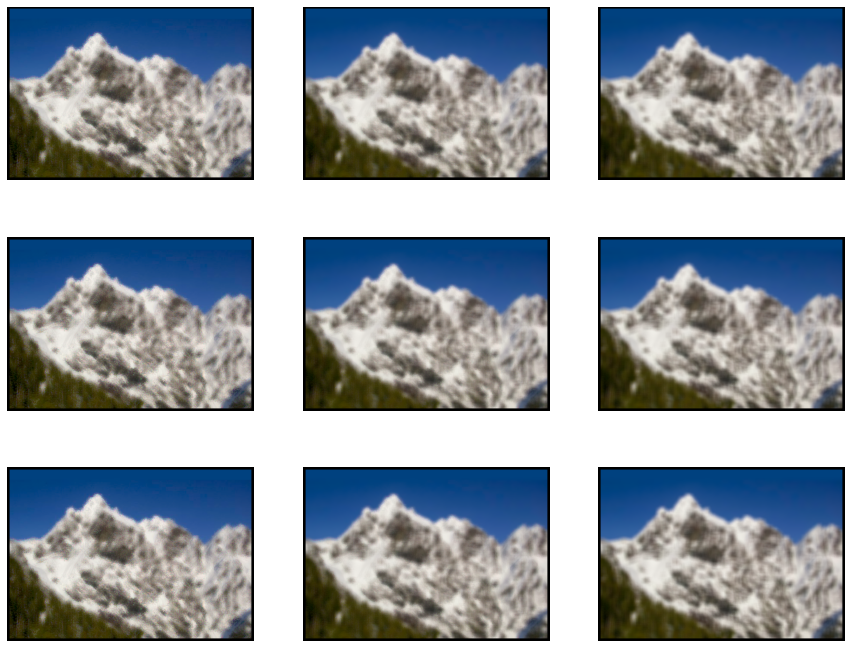

In [25]:
plt.figure(figsize = (15,12))

for i in range(3):
    for j in range(3):
        plt.subplot(3,3,3*i+j+1)
        plt.axis("off")
        plt.imshow(bilateral(img_color, 13, (i)*30+10, (j)*3+1))

#### OBSERVATIONS: We can see that increasing σr leads to gaussian blur type effect while increasing σs leads to edge preservation. Increasing both to large valuse leads to complete blurring without any edge preservance.

## Q4) Rain removal

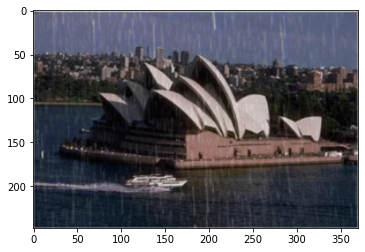

In [26]:
img_rain = cv2.imread("../images/rain.png")
img_rain = cv2.cvtColor(img_rain, cv2.COLOR_BGR2RGB)
plt.imshow(img_rain)

### 1. Apply gaussian filter on rain.png. Report the σ value and filter size for the best output.

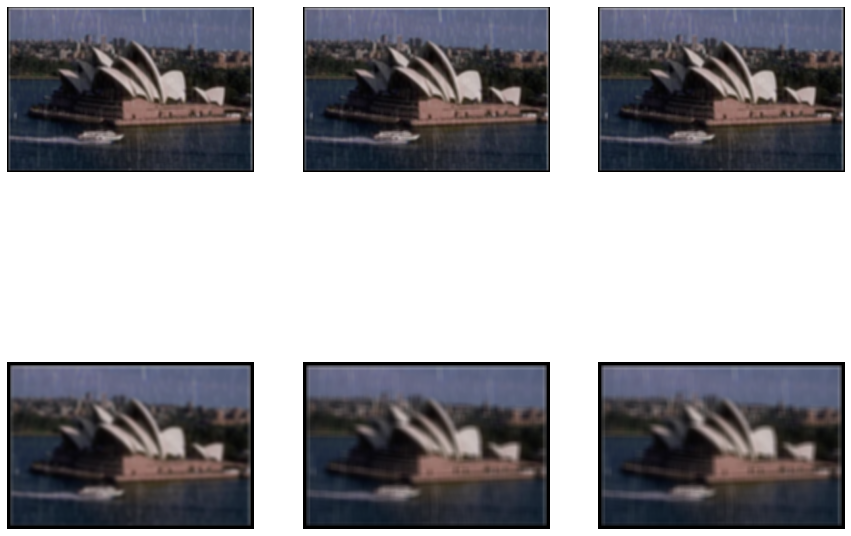

In [27]:
def colorgaussian(img, k, sigma):
    img = padding(img, k, 0)
    b, l, _ = img.shape
    out = np.copy(img)
    kernel = np.zeros((k,k))
    s = 2*(sigma**2)
    for i in range(k):
        for j in range(k):
            kernel[i][j] = (1/pi*s)*(exp((-1)*((((i-k//2)**2) + ((j-k//2)**2))/s)))
    #print(kernel)
    kernel *= 1/(kernel[0][0])
    
    for i in range(k):
        for j in range(k):
            kernel[i][j] = floor(kernel[i][j])
    kernel /= np.sum(kernel)
    
    for i in range(k//2,(b-(k//2))):
        for j in range(k//2,(l-(k//2))):
            for c in range(3):
                p= k//2
                if k != 1:
                    tmp = img[i-p:i+p+1,j-p:j+p+1,c:c+1].reshape(k,k)
                else:
                    tmp = img[i][j][c]
                out[i][j][c] = floor(np.sum(tmp*kernel))
            
    return out

plt.figure(figsize = (15,12))

plt.subplot(231)
plt.axis("off")
plt.imshow(colorgaussian(img_rain, 5,3))
plt.subplot(232)
plt.axis("off")
plt.imshow(colorgaussian(img_rain, 5,7))
plt.subplot(233)
plt.axis("off")
plt.imshow(colorgaussian(img_rain, 5,11))
plt.subplot(234)
plt.axis("off")
plt.imshow(colorgaussian(img_rain, 11,3))
plt.subplot(235)
plt.axis("off")
plt.imshow(colorgaussian(img_rain, 11,7))
plt.subplot(236)
plt.axis("off")
plt.imshow(colorgaussian(img_rain, 11,11))

### 2. Apply median filter on rain.png. Report the filter size for the best ouptput.

(248, 371, 3)


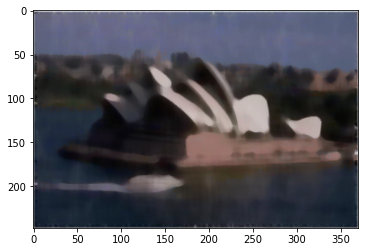

In [28]:
def colormedianFilter1(img, k):
    b ,l, c = img.shape
    gray = cvtGrayscale(img)
    tmp = np.zeros((k,k))
    out = np.copy(img)
    p = k//2
    for i in range(k//2,(b-(k//2))):
        for j in range(k//2,(l-(k//2))):
            if k != 1:
                tmp = gray[i-p:i+p+1,j-p:j+p+1]
            else:
                tmp = gray[i][j]
            index = np.where(tmp == np.median(tmp))
            u = index[0][0]
            v = index[1][0]
            out[i:i+1,j:j+1,0:3] = img[u+i-p][v+j-p]
    return out

print(img_rain.shape)
plt.imshow(colormedianFilter1(img_rain, 11))

#### Observed best filter size = 11

### 3. Apply bilateral filter on rain.png. Report the σ values(domain and range components) and filter size for the best output.

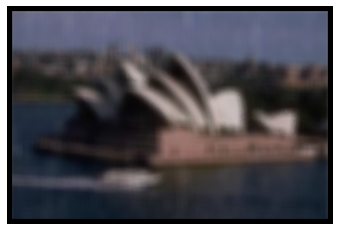

In [29]:
plt.axis("off")
plt.imshow(bilateral(img_rain, 13, 21, 7))

#### sigma values = (21,7)

### 4. Compare the outputs from the above three filters and report your observations. Feel free to try out any other methods to achieve the intended result.

#### OBSERVATION: Of the three methods median filter introduces maximum change to objects in the image that arent noise, gaussian introduces a uniform blurring effect, while bilateral filters create the least amount of artifacts.Though complete rain removal is seen in the case of median filter, while gaussian and bilateral tend to require excessive blurring of the images to completely get rid of the images.

## Q5) Cartoon Creation

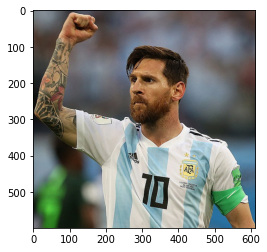

In [30]:
img_messi = cv2.imread("../images/messi.jpg")
img_messi = cv2.cvtColor(img_messi, cv2.COLOR_BGR2RGB)
plt.imshow(img_messi)

### 1. Apply the bilateral filtering to the color image. Keep this filtered image aside for the last step.

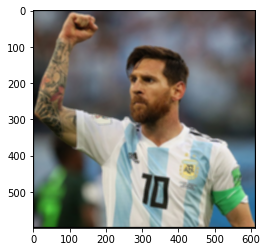

In [31]:
img_bifil = bilateral(img_messi, 7, 50, 5)
plt.imshow(img_bifil)

### 2. Now, take a copy of original color image, convert it to gray scale.

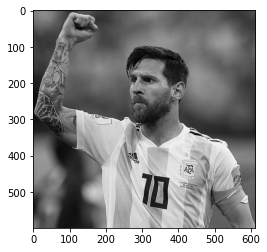

In [32]:
img_gray = cvtGrayscale(img_messi)
plt.imshow(img_gray, cmap="gray")

### 3. Apply blurring on this gray scale image to reduce noise. [ You can try different variants of blurring(box filter, gaussian filter, repeated gaussian filter,..) with different filter sizes and see the performance ]

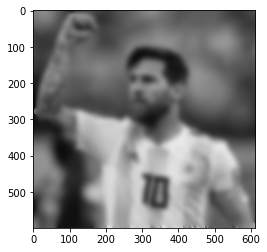

In [33]:
img_blurred = np.copy(img_gray)
for i in range(5):
    img_blurred = gaussian(img_blurred, 13, 4)
plt.imshow(img_blurred, cmap="gray")

### 4. Now, create an edge mask from this blurred, gray scale image. An edge mask can be obtained using adaptive thresholding.

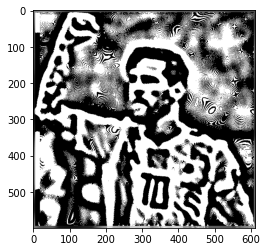

In [34]:
def adaptiveThreshold(img, k):
    b ,l = img.shape
    out = np.copy(img)
    p = k//2
    rcol = k
    lcol = 0

    for i in range(k//2,(b-(k//2))):
        rcol = k
        lcol = 0
        tmp = img[i-p:i+p+1,lcol:rcol]
        for j in range(k//2,(l-(k//2))):
            if out[i][j] < np.mean(tmp):
                out[i][j] = 0
            else:
                out[i][j] = 255
            rcol += 1
            #delta = np.sum(img[i-p:i+p+1,min(rcol-1,l-1)] - img[i-p:i+p+1,lcol])
            tmp[0:k,0:k-1] = tmp[0:k, 1:k]
            tmp[0:k,k-1] = img[i-p:i+p+1,min(rcol-1,l-1)]
            lcol += 1
    return out
img_mask = adaptiveThreshold(img_blurred, 13)
plt.imshow(img_mask, cmap="gray")

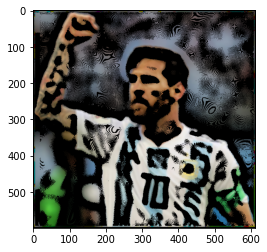

In [35]:
img_final = np.copy(img_bifil)
for c in range(3):
    img_final[:,:,c] = img_mask&img_bifil[:,:,c]
plt.imshow(img_final)

## Q6) Unsharp Masking and Highboost filtering
### 1. Implement Unsharp Masking and apply it to orion.jpg.
### 2. Implement Highboost Filtering and apply it to orion.jpg. Increase the coefficient values for the edge mask and report your observations. (Take the same filter size as in unsharp Masking.)

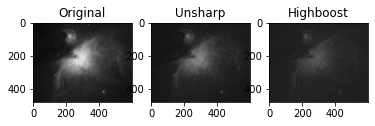

In [36]:
def unsharp(img, k):
    b, l = img.shape
    out = np.copy(img)
    c = ceil((k-1)/6)
    if c == 0:
        c = 1
    blur = gaussian(img, k, c)
    out = img + (img-blur) 
    return out

def highboost(img, k, boost):
    b, l = img.shape
    out = np.copy(img)
    blur = gaussian(img, k, ceil((k-1)/6))
    out = img + boost*(img-blur) 
    return out

img_orion = cv2.imread("../images/orion.jpg")
img_orion = cvtGrayscale(img_orion)
plt.subplot(131)
plt.title("Original")
plt.imshow(img_orion, cmap="gray")
plt.subplot(132)
plt.title("Unsharp")
plt.imshow(unsharp(img_orion, 21), cmap="gray")
plt.subplot(133)
plt.title("Highboost")
plt.imshow(highboost(img_orion, 21, 3), cmap="gray")



### 3. Choose any three different filter sizes. Compare the two methods for each filter size and report your observations along with the images.

 Kernel size = 5
 Kernel size = 7
 Kernel size = 9


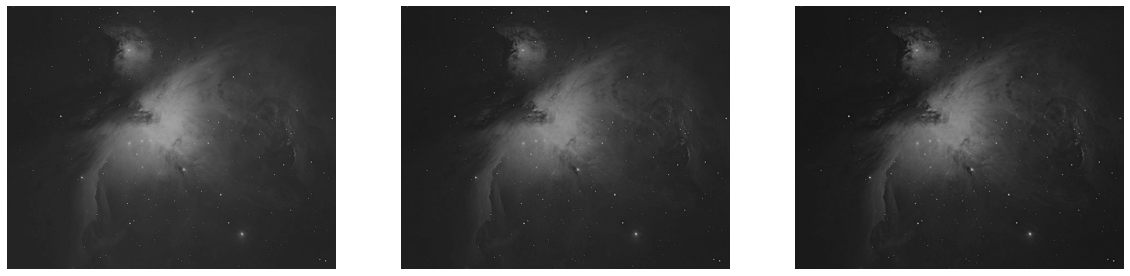

In [37]:
fig = plt.figure(figsize = (20,10))
for i in range(1,4): 
    ax = fig.add_subplot(1,3,i)
    t = " Kernel size = " + str(2*i+3)
    print(t)
    ax.imshow(unsharp(img_orion, 4*i + 3), cmap="gray")
    ax.axis("off")

 Kernel size = 5
 Kernel size = 7
 Kernel size = 9


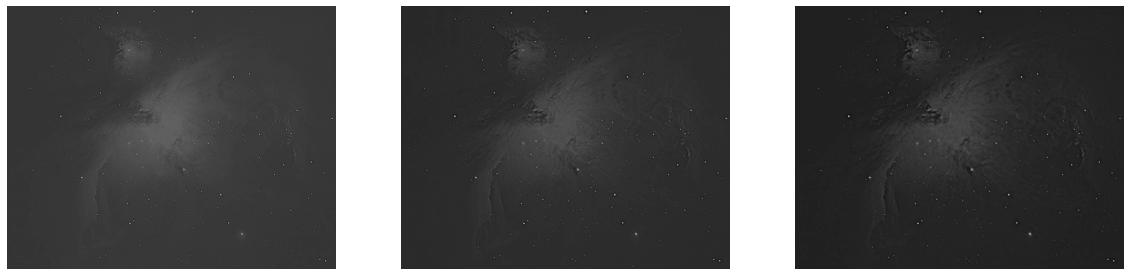

In [38]:
fig = plt.figure(figsize = (20,10))
for i in range(1,4): 
    ax = fig.add_subplot(1,3,i)
    t = " Kernel size = " + str(2*i+3)
    print(t)
    ax.imshow(highboost(img_orion, 4*i + 3, 5), cmap="gray")
    ax.axis("off")

#### OBSERVATION: Both methods manage to brighten stars which are the high frequency bits of the image. In case of unsharp, remaining low frequency regions are mostly unaffected. Though, highboost filtering reduces the intesity of low frequency regions in addition to brightening high frequency regions

## Q7) Fourier Transform
### 1. Implement 2D DFT.

/tmp/ipykernel_4668/1562545905.py:16: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  out[m][n] += img[i][j]*np.exp(-2*np.pi*np.complex(0,((i*m)/b + (j*n)/l)))


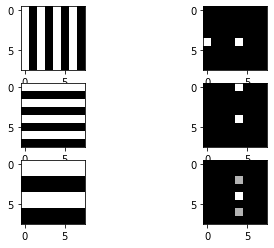

In [39]:
def complex_modulo(z):
    a = z.real
    b = z.imag
    return np.sqrt(a**2+b**2)

img_checker = np.array([[255,0,255,0,255,0,255,0],[255,0,255,0,255,0,255,0],[255,0,255,0,255,0,255,0],[255,0,255,0,255,0,255,0],[255,0,255,0,255,0,255,0],[255,0,255,0,255,0,255,0],[255,0,255,0,255,0,255,0],[255,0,255,0,255,0,255,0]])
img_checker1 = np.array([[255,255,255,255,255,255,255,255],[0,0,0,0,0,0,0,0],[255,255,255,255,255,255,255,255],[0,0,0,0,0,0,0,0],[255,255,255,255,255,255,255,255],[0,0,0,0,0,0,0,0],[255,255,255,255,255,255,255,255],[0,0,0,0,0,0,0,0]])
img_checker2 = np.array([[255,255,255,255,255,255,255,255],[255,255,255,255,255,255,255,255],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[255,255,255,255,255,255,255,255],[255,255,255,255,255,255,255,255],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0]])
def DFT(img):
    out = np.zeros(img.shape, complex)
    b, l= img.shape
    for m in range(b):
        for n in range(l):
            for i in range(b):
                for j in range(l):
                    out[m][n] += img[i][j]*np.exp(-2*np.pi*np.complex(0,((i*m)/b + (j*n)/l)))
    return out

dft = DFT(img_checker)
plt.subplot(321)
plt.imshow(img_checker, cmap="gray")
plt.subplot(322)
plt.imshow(np.abs(np.fft.fftshift(dft)).astype("int64"), cmap="gray")
dft1 = DFT(img_checker1)
plt.subplot(323)
plt.imshow(img_checker1, cmap="gray")
plt.subplot(324)
plt.imshow(np.abs(np.fft.fftshift(dft1)).astype("int64"), cmap="gray")
dft2 = DFT(img_checker2)
plt.subplot(325)
plt.imshow(img_checker2, cmap="gray")
plt.subplot(326)
plt.imshow(np.abs(np.fft.fftshift(dft2)).astype("int64"), cmap="gray")

### 2. Implement 1D FFT. Use it to implement 2D FFT and display the result on suitableimages of your choice. Compare the runtimes of your version of DFT and FFT on different sized images(as in Q1) and plot them.

/tmp/ipykernel_4668/731154499.py:18: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  temp1=-2*pi*np.complex(0,1)


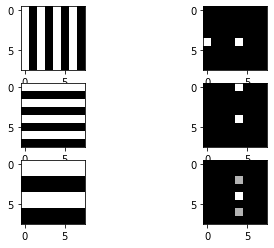

In [40]:
def onedFFT(arr):
    num = arr.shape[0]
    if num==1:
        return arr

    if np.log2(num)-int(np.log2(num)) != 0.0:
        padding = 2**(int(np.log2(num))+1)
        padding-=num
        arr = np.append(arr, np.zeros(padding))
        
    num = arr.shape[0]
    evenarr = arr[0:num:2]
    oddarr = arr[1:num:2]
    
    eveny = onedFFT(evenarr)
    oddy = onedFFT(oddarr)
    y= []
    temp1=-2*pi*np.complex(0,1)
    temp2=np.array(range(int(num/2)))
    E = np.array(np.exp((temp1*temp2)/num))
    
    
    y = eveny + E * oddy
    y = np.append(y, eveny - E * oddy)
    
    return y

def twodFFT(arr):
    b,l = arr.shape
    y = np.zeros(arr.shape,dtype='complex')
    for i in range(b):
        y[i,:] = onedFFT(arr[int(i),:])[:l]
    copyy = np.copy(y)
    for i in range(l):
        y[:,i] = onedFFT(copyy[:,int(i)])[:b]
    
    return y
#onedFFT twodFFT
fft2d = twodFFT(img_checker)
plt.subplot(321)
plt.imshow(img_checker, cmap="gray")
plt.subplot(322)
plt.imshow(np.abs(np.fft.fftshift(fft2d)).astype("int64"), cmap="gray")
fft2d1 = twodFFT(img_checker1)
plt.subplot(323)
plt.imshow(img_checker1, cmap="gray")
plt.subplot(324)
plt.imshow(np.abs(np.fft.fftshift(fft2d1)).astype("int64"), cmap="gray")
fft2d2 = twodFFT(img_checker2)
plt.subplot(325)
plt.imshow(img_checker2, cmap="gray")
plt.subplot(326)
plt.imshow(np.abs(np.fft.fftshift(fft2d2)).astype("int64"), cmap="gray")

### 3. Similarly, implement 2D inverse FFT

/tmp/ipykernel_4668/731154499.py:18: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  temp1=-2*pi*np.complex(0,1)


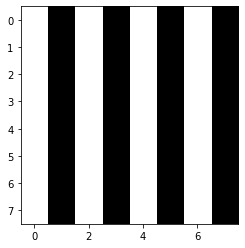

In [41]:
def twodIFFT(X):
    h,w = X.shape
    
    x = np.zeros(X.shape,dtype='complex')
    
    for i in range(h):
        temp=onedFFT(np.conj(X[int(i),:]))
        x[i,:] = np.conj(temp[:w])/w
    copyx = np.copy(x)
    for i in range(w):
        temp=onedFFT(np.conj(copyx[:,int(i)]))
        x[:,i] = np.conj(temp[:h])/h
    
    ans=x/h*w
    return ans
plt.imshow(np.abs(twodIFFT(np.abs(np.fft.fftshift(fft2d)).astype("int64"))), cmap="gray")

## Q8) Low Pass Filtering using Fourier Transfrom

### 1. Apply ideal lowpass filter of cutoff radius, D = 30 in the frequency domain for image mountain.png. Also try for D = 15 and 50. Include the original image and all three ideal lowpass filtered images and briefly discuss your results.

/tmp/ipykernel_4668/1562545905.py:16: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  out[m][n] += img[i][j]*np.exp(-2*np.pi*np.complex(0,((i*m)/b + (j*n)/l)))
/tmp/ipykernel_4668/731154499.py:18: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  temp1=-2*pi*np.complex(0,1)


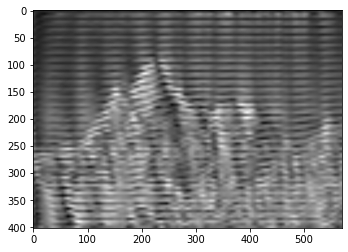

In [42]:
def idealLowPass(img, D):
    b,l = img.shape
    resize = False
    if b*l > 10000:
        d = np.sqrt(b*l/10000)
        img = cv2.resize(img.astype('float32'), (int(l/d), int(b/d)))
        b = int(b/d)
        l = int(l/d)
        resize = True

    dft = DFT(img)
    dft_shift = np.fft.fftshift(dft)
    pass_mask = np.zeros((b, l), np.uint8)
    x, y = np.ogrid[:b, :l]
    condn = (x - int(b/2) )** 2 + (y - int(l/2)) ** 2 <= D*D
    pass_mask[condn] = 1
    
    fshift = dft_shift * pass_mask
    out = np.abs(twodIFFT(np.fft.ifftshift(fshift)))
    out = cv2.resize(out, (int(l*d), int(b*d)))
    
    return out

plt.imshow(idealLowPass(img_mount,30), cmap="gray")

### 2. Apply gaussion lowpass filter in the frequency domain for image mountain.png. Try for D 0 values = 30, 15 and 50 (D 0 refers to the measure of spread in a gaussian curve). Include the original image and all three gaussian lowpass filtered images and briefly discuss your results.

/tmp/ipykernel_4668/1562545905.py:16: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  out[m][n] += img[i][j]*np.exp(-2*np.pi*np.complex(0,((i*m)/b + (j*n)/l)))
/tmp/ipykernel_4668/731154499.py:18: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  temp1=-2*pi*np.complex(0,1)


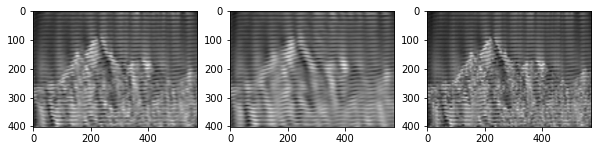

In [43]:
def gaussianLowPAss(img, D):
    b,l = img.shape
    
    resize = False
    if b*l > 10000:
        d = np.sqrt(b*l/10000)
        img = cv2.resize(img.astype('float32'), (int(l/d), int(b/d)))
        b = int(b/d)
        l = int(l/d)
        resize = True
        
    dft = DFT(img)
    dft_shift = np.fft.fftshift(dft)
    gauss = np.copy(dft_shift)
    s = 2*(D*D)
    for i in range(gauss.shape[0]):
        for j in range(gauss.shape[1]):
            gauss[i][j] = (exp((-1)*((((i-(gauss.shape[0]))//2)**2) + ((j-(gauss.shape[1])//2)**2))/s))
    gshift = (dft*gauss)*(1/np.sum(gauss))
    out = np.abs(twodIFFT(np.fft.ifftshift(gshift)))
    out = cv2.resize(out, (int(l*d), int(b*d)))
    
    return out

plt.figure(figsize=(10,20))
plt.subplot(131)
plt.imshow(idealLowPass(img_mount,30), cmap="gray")
plt.subplot(132)
plt.imshow(idealLowPass(img_mount,15), cmap="gray")
plt.subplot(133)
plt.imshow(idealLowPass(img_mount,50), cmap="gray")

### 3. Discuss the difference between your results for gaussian lowpass filtering and ideal lowpass filtering.

#### Gussian low pass filter avoids the ringing effect that can be observed in the ideal low pass filter case

## Q9) Morphological Operations

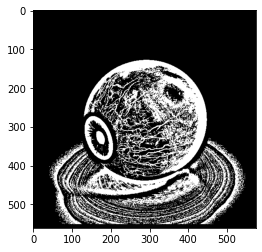

In [44]:
img_eye = cv2.imread("../images/eye.png")
img_eye = cv2.cvtColor(img_eye, cv2.COLOR_BGR2RGB)
img_binary = 255 - adaptiveThreshold(cvtGrayscale(img_eye), 21)
plt.imshow(img_binary, cmap="gray")

### Explain the combination of operations and choice of structuring element used while performing morphological gradient on the input image eye.png.

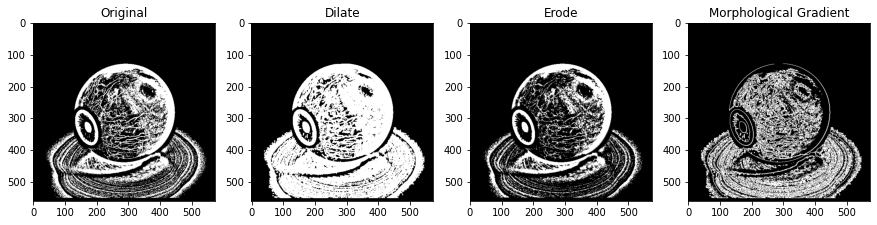

In [45]:
def dilation(img, SE, k):
    b, l = img.shape
    out = np.copy(img)
    window = np.copy(SE)
    p = k//2
    for i in range(k//2,(b-(k//2))):
        for j in range(k//2,(l-(k//2))):
            if img[i][j] == 255 and k!= 1:
                
                tmp = img[i-p:i+p+1,j-p:j+p+1]
                

                for u in range(k):
                    for v in range(k):
                        if tmp[u][v] == 255 or SE[u][v] == 255:
                            window[u][v] = 255

                out[i-p:i+p+1,j-p:j+p+1] = window

    return out

def erode(img, SE, k):
    b, l = img.shape
    out = np.copy(img)
    window = np.copy(SE)
    p = k//2
    for i in range(k//2,(b-(k//2))):
        for j in range(k//2,(l-(k//2))):
            if img[i][j] == 255 and k!= 1:
                
                tmp = img[i-p:i+p+1,j-p:j+p+1]
                window = np.copy(tmp)

                for u in range(k):
                    for v in range(k):
                        if tmp[u][v] == 255 and SE[u][v] == 255:
                            window[u][v] = 0

                out[i-p:i+p+1,j-p:j+p+1] = window

    return out
se = np.array([[0,255,0],[255,255,255],[0,255,0]])
plt.figure(figsize = (15,20))
plt.subplot(141)
plt.title("Original")
plt.imshow(img_binary, cmap="gray")
dil = dilation(img_binary, se, 3)
plt.subplot(142)
plt.title("Dilate")
plt.imshow(dil, cmap="gray")
plt.subplot(143)
plt.title("Erode")
er = erode(img_binary,se,3)
plt.imshow(er, cmap="gray")
plt.subplot(144)
plt.title("Morphological Gradient")
plt.imshow(dil - er, cmap="gray")

## Q10) Geometrical Transformations

### 1. Write a function rotImage which rotates an input image about its center and takes the following parameters:
### • Input Image
### • Angle of rotation in degrees

(599, 612)


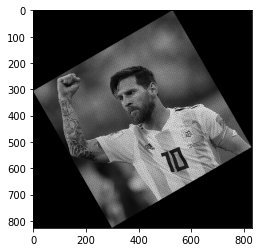

In [46]:
def rotImage(img, theta):
    theta = radians(theta)
    print(img.shape)
    b, l = img.shape
    h = ceil(l*np.sin(theta) + b*np.cos(theta))+1
    w = ceil(b*np.sin(theta) + l*np.cos(theta))+1
    out = np.zeros((h,w), dtype="int64")
    for i in range(b):
        for j in range(l):
            m=i-b/2;
            n=j-l/2;
            x = floor(m*np.cos(theta) - n*np.sin(theta)+h/2)
            y = floor(m*np.sin(theta) + n*np.cos(theta)+w/2)
            out[x][y] = img[i][j]
    return out
plt.imshow(rotImage(img_gray, 30),cmap="gray")

### 2. Show outputs of a rectangular image of your choice with angle 30°, 45°, 90° and 2 other angles of your choice.

(599, 612)
(599, 612)
(599, 612)
(599, 612)
(599, 612)
(599, 612)


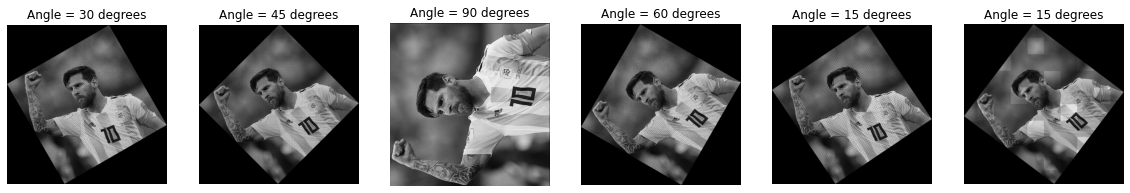

In [51]:
plt.figure(figsize = (20,12))
plt.subplot(161)
plt.axis("off")
plt.title("Angle = 30 degrees")
plt.imshow(rotImage(img_gray, 30),cmap="gray")
plt.subplot(162)
plt.axis("off")
plt.title("Angle = 45 degrees")
plt.imshow(rotImage(img_gray, 45),cmap="gray")
plt.subplot(163)
plt.axis("off")
plt.title("Angle = 90 degrees")
plt.imshow(rotImage(img_gray, 90),cmap="gray")
plt.subplot(164)
plt.axis("off")
plt.title("Angle = 60 degrees")
plt.imshow(rotImage(img_gray, 60),cmap="gray")
plt.subplot(165)
plt.axis("off")
plt.title("Angle = 15 degrees")
plt.imshow(rotImage(img_gray, 34),cmap="gray")
plt.subplot(166)
plt.axis("off")
plt.title("Angle = 15 degrees")
plt.imshow(rotImage(img_gray, 53),cmap="gray")

## Q11) Image Denoising

### Use a combination of any of the techniques in this assignment to bring corruptedLena.jpg as close to lena.jpg as possible. Explain your process.

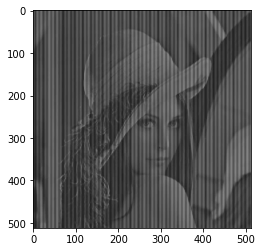

In [48]:
img_last = cv2.imread("../images/corruptedLena.jpg")
img_last = cv2.cvtColor(img_last, cv2.COLOR_BGR2RGB)
img_last = cvtGrayscale(img_last)
plt.imshow(img_last, cmap="gray")

/tmp/ipykernel_4668/1562545905.py:16: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  out[m][n] += img[i][j]*np.exp(-2*np.pi*np.complex(0,((i*m)/b + (j*n)/l)))
/tmp/ipykernel_4668/731154499.py:18: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  temp1=-2*pi*np.complex(0,1)


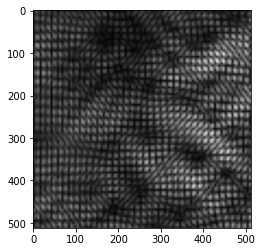

In [50]:
def bandpass(img, d1, d2):
    b,l = img.shape
    if b*l > 10000:
        d = np.sqrt(b*l/10000)
        img = cv2.resize(img.astype('float32'), (int(l/d), int(b/d)))
        b = int(b/d)
        l = int(l/d)
        
    dft = DFT(img)
    dft_shift = np.fft.fftshift(dft)
    pass_mask = np.zeros((b, l))
    x, y = np.ogrid[:b, :l]
    condn = (x - int(b/2) )** 2 + (y - int(l/2)) ** 2 <= d2*d2
    pass_mask[condn] = 1
    x, y = np.ogrid[:b, :l]
    condn = (x - int(b/2) )** 2 + (y - int(l/2)) ** 2 <= d1*d1
    pass_mask[condn] = 0
    
    fshift = dft_shift * pass_mask
    out = np.abs(twodIFFT(np.fft.ifftshift(fshift)))
    out = cv2.resize(out, (int(l*d), int(b*d)))
    
    return out

plt.imshow(bandpass(img_last, 9, 12), cmap="gray")

[232 115  26]


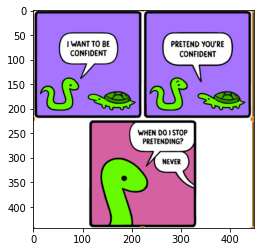

In [16]:
img = cv2.imread("ss5.png")
print(img[0][0])
plt.imshow(img)

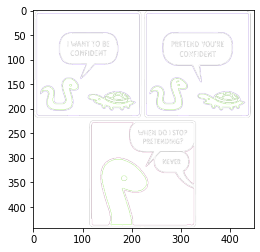

In [24]:
out = np.zeros((img.shape[0],img.shape[1],img.shape[2]+1), dtype=np.uint8)
out[:,:,:3] = img
b, l = img.shape[:2]
for i in range(b):
    for j in range(l):
        if np.sum(img[i][j]) <= 50*3:
            out[i][j] = [255,255,255,255]
        else:
            out[i][j][3] = 0

plt.imshow(out)
plt.imsave("out.png", out)